## Batch Effect Testing 
We used t-SNE plot and PCA plot ML1, ML2, and ML4 datasets. Datasets are separated with different colors and the regression value with different shapes.<br>

In this notebook following experiments are performed <br>
1. Tested batch effect in a raw dataset where no features in any dataset have performed any normalization.<br>
     Observation: A batch effect is seen for the ML4 dataset for 8 and 16 concentrations.

2. Tested Batch Effect in min-max normalized dataset. <br>
        Method: Performed min-max normalization for each feature in the dataset separately.<br>
        Observation: Batch effect is slightly reduced when using min-max normalization

3. Tested Batch Effect using ComBat Normalization.
        Method: Performed ComBat Normalization after performing min-max Normalization. <br>
        Observation: After performing ComBat Normalization Ml1, Ml2, and ML4 dataset has close distribution and in the plots the clusters are
        grouped according to the concentration instead of batches.

4. Tested Batch Effect using Z-Score Normalization.
        Method: Performed Z-score Normalization. <br>
        Observation: After performing Z-score Normalization Ml1, Ml2, and ML4 dataset has close distribution and in the plots, the clusters           are grouped according to the concentration instead of batches.
       
   


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

from src.load_dataset import load_dataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from pycombat import Combat

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'src'

In [ ]:
def tsen_pca_viz(data, batch_labels, labels, filename=''):
    tsne        = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(data)
    
    # Convert t-SNE result to a DataFrame for easier plotting
    tsne_df          = pd.DataFrame(data=tsne_result, columns=['t-SNE1', 't-SNE2'])
    tsne_df['Batch'] = batch_labels
    tsne_df['labels'] = labels

    os.makedirs('batch_effect', exist_ok=True)
    
    # Plot t-SNE

    fig, axs = plt.subplots(4, 1, figsize=(15, 12))
    
    sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Batch', style='labels', data=tsne_df, palette='deep', markers=['o', 's', '^'], s=20, ax=axs[0])
    axs[0].set_title('t-SNE: Batch Effect Visualization')
    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    

    
    # Perform PCA
    pca        = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    
    # Convert PCA result to a DataFrame for easier plotting
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    pca_df['Batch']  = batch_labels
    pca_df['labels'] = labels
    
    # Plot PCA
    sns.scatterplot(x='PC1', y='PC2', hue='Batch', style='labels', data=pca_df, palette='deep', markers=['o', 's', '^'], s=20, ax=axs[1])
    axs[1].set_title('PCA: Batch Effect Visualization')
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(4,1,3)
    sns.kdeplot(data=pca_df, x='PC1', hue='Batch', fill=True, common_norm=False, palette='deep', alpha=0.5)
    # axs[2].set_title('Density Plot')
    axs[2].set_xlabel('PCA Component Value')
    axs[2].set_ylabel('Density')

    plt.subplot(4,1,4)
    sns.kdeplot(data=pca_df, x='PC2', hue='Batch', fill=True, common_norm=False, palette='deep', alpha=0.5)
    # axs[3].set_title('Density Plot')
    axs[3].set_xlabel('PCA Component Value')
    axs[3].set_ylabel('Density')

    plt.savefig(f'batch_effect/{filename}.png', dpi=300)

    # plt.savefig(f'batch_effect/density_plot_{filename}.png', dpi=300)

In [109]:
ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/ML1_ML2/2024_02_19_ML1', normalization=False, split=False)
ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/ML1_ML2/2024_02_22_ML2', normalization=False, split=False)
ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/ML4', normalization=False, split=False)

/Users/sangam/Desktop/Epilepsey/Code/vgramreg/src/load_dataset.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={"PH": 'univariate, max(S)', 'signal_std':'univariate, std(S)', 'signal_mean':'univariate, mean(S)', 'peak area':'univariate, area(S)', \
/Users/sangam/Desktop/Epilepsey/Code/vgramreg/src/load_dataset.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={"PH": 'univariate, max(S)', 'signal_std':'univariate, std(S)', 'signal_mean':'univariate, mean(S)', 'peak area':'univariate, area(S)', \
/Users/sangam/Desktop/Epilepsey/Code/vgramreg/src/load_dataset.py:60: SettingWithCop

In [110]:
conc         = 'all'
data         = pd.concat([ML1_X, ML2_X, ML4_X]) if conc=='all' else pd.concat([ML1_X[ML1_y==conc], ML2_X[ML2_y==conc], ML4_X[ML4_y==conc]])
batch_labels = np.repeat(['ML1', 'ML2', 'ML4'], repeats= [len(ML1_X), len(ML2_X), len(ML4_X)] if conc=='all' else [ML1_y.value_counts()[conc], ML2_y.value_counts()[conc], ML4_y.value_counts()[conc]])
labels       = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()

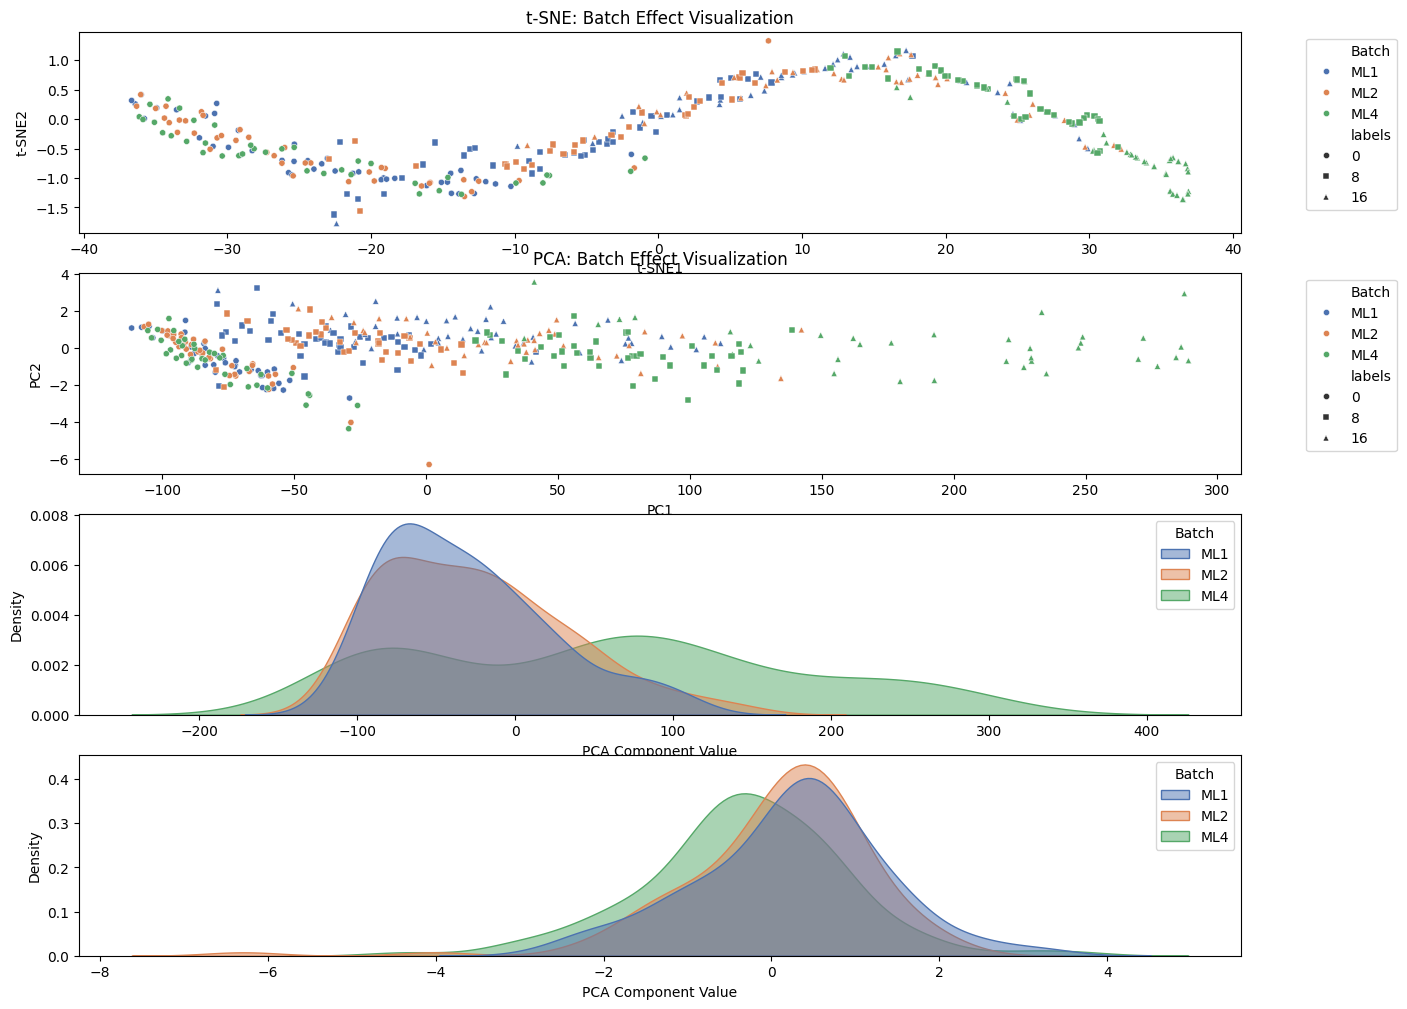

In [112]:
experiment_name = 'batch_effect_raw'
tsen_pca_viz(data, batch_labels, labels, filename=experiment_name)

In [113]:
features = data.values

# Apply ComBat
combat      = Combat()
combat_data = combat.fit_transform(features, batch_labels)
combat_df   = pd.DataFrame(combat_data, columns=data.columns)
combat_df

,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)"
0,5.103119,100.015934,1.058035,1.058557,0.078243,0.007278,0.019031,1.728377,-2.009270,3.775095,1.028901,1.080366,0.156522
1,4.036601,94.606573,1.058440,1.058557,0.064216,0.005764,0.015354,1.457001,-1.721752,3.213312,1.033021,1.084328,0.128406
2,11.160583,241.599317,1.056721,1.058557,0.175436,0.015944,0.042223,3.781405,-4.661546,8.483068,1.033021,1.080366,0.350906
3,6.772780,163.870192,1.070370,1.074010,0.112314,0.009616,0.026526,2.526311,-3.214907,5.772560,1.041259,1.092251,0.224599
4,9.598192,244.425909,1.056620,1.058557,0.151852,0.013743,0.036142,3.365016,-3.837571,7.253484,1.028901,1.080366,0.303666
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,-0.516548,26.895609,0.964975,1.014414,-0.002865,-0.000775,0.000471,0.153595,-0.172030,0.266826,1.073687,1.002805,-0.005702
357,0.783719,38.307362,0.986227,0.997713,0.008250,0.001146,0.002368,0.275019,-0.199204,0.413239,0.938536,1.037206,0.016523
358,0.393141,12.577984,0.979207,0.997713,0.002785,0.000577,0.001104,0.212315,-0.107190,0.258277,0.964815,1.037206,0.005586
359,0.291211,42.655366,0.962034,1.018589,0.002110,0.000434,0.000752,0.184773,-0.123131,0.247609,0.976078,1.056318,0.004184


In [114]:
combat = Combat()
scaler = combat.fit(data.values, batch_labels)

result = scaler.transform(data.values[0:3], ['ML1', 'ML2', 'ML4'])
result

array([[ 5.10311865e+00,  1.00015934e+02,  1.05803535e+00,
         1.05855658e+00,  7.82430325e-02,  7.27765148e-03,
         1.90306594e-02,  1.72837694e+00, -2.00926956e+00,
         3.77509474e+00,  1.02890137e+00,  1.08036649e+00,
         1.56522071e-01],
       [ 3.93498188e+00,  8.78373452e+01,  1.06179252e+00,
         1.06165042e+00,  6.10449970e-02,  5.61909565e-03,
         1.47310131e-02,  1.37163580e+00, -1.52925102e+00,
         2.98199709e+00,  1.03489331e+00,  1.09036035e+00,
         1.22066194e-01],
       [ 5.73127562e+00,  1.12447705e+02,  1.05785829e+00,
         1.06034238e+00,  8.40445601e-02,  8.18924222e-03,
         2.07058339e-02,  1.80179287e+00, -1.97873194e+00,
         3.71620007e+00,  1.02863670e+00,  1.08689610e+00,
         1.68103224e-01]])

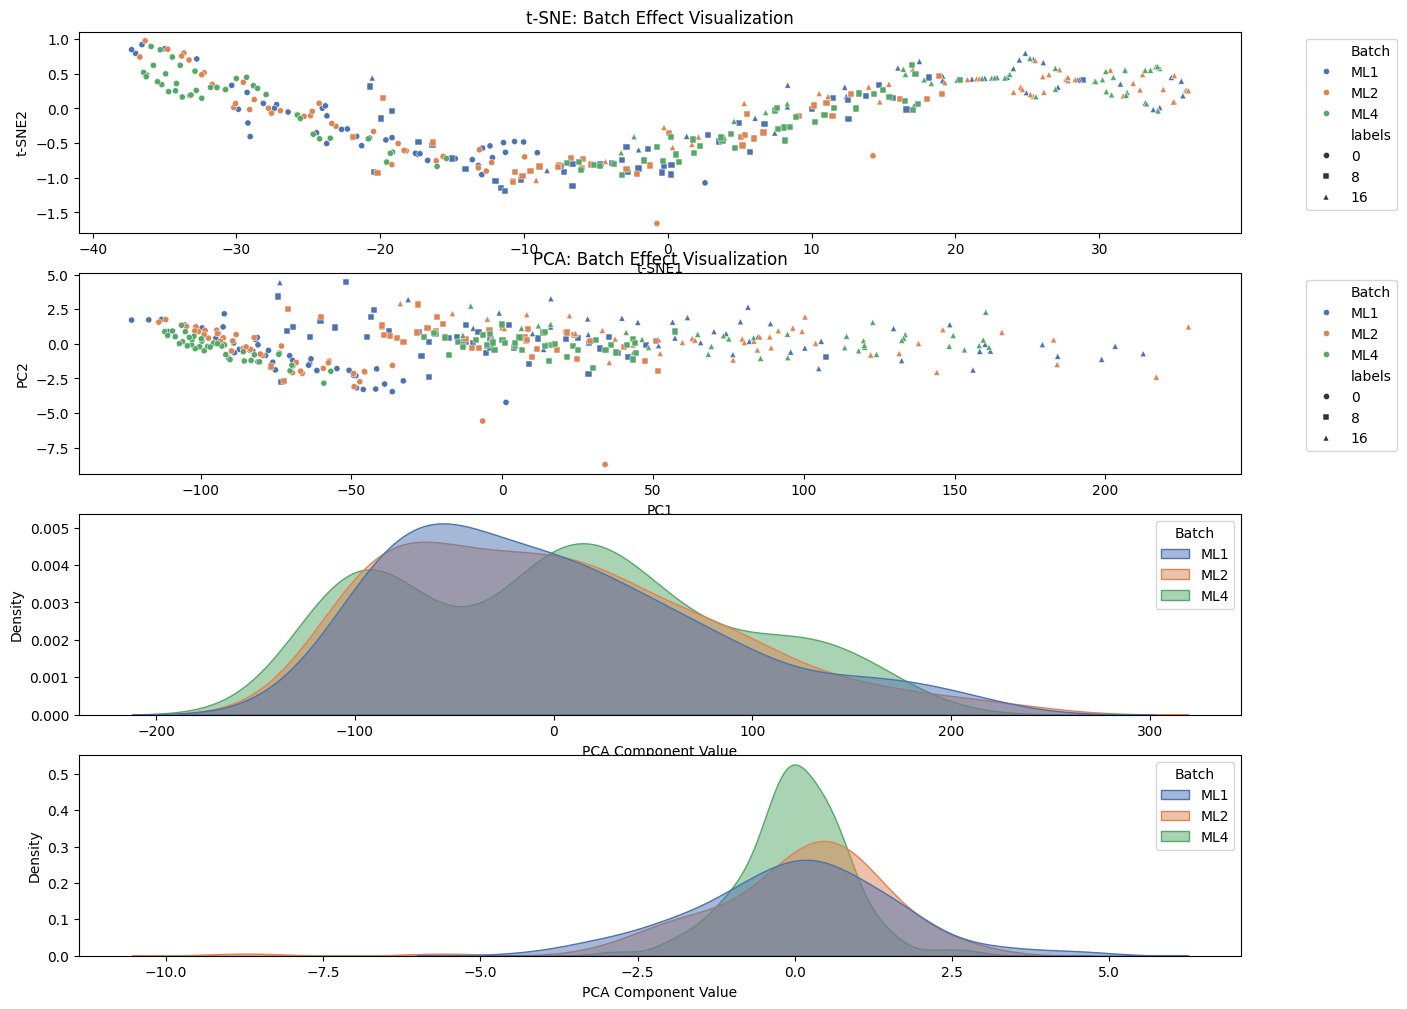

In [115]:
experiment_name = 'batch_effect_ComBat_withoutNorm'
tsen_pca_viz(combat_df, batch_labels, labels, filename=experiment_name)

## ComBat after Normalization (MinMax)

In [119]:
# Load normalized dataset
normalization    = True
standardize_type = 'min_max'

ML1_X, ML1_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=False)
ML2_X, ML2_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=False)
ML4_X, ML4_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/ML4', normalization=normalization, standardize_type=standardize_type, split=False)

/Users/sangam/Desktop/Epilepsey/Code/vgramreg/src/load_dataset.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={"PH": 'univariate, max(S)', 'signal_std':'univariate, std(S)', 'signal_mean':'univariate, mean(S)', 'peak area':'univariate, area(S)', \
/Users/sangam/Desktop/Epilepsey/Code/vgramreg/src/load_dataset.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={"PH": 'univariate, max(S)', 'signal_std':'univariate, std(S)', 'signal_mean':'univariate, mean(S)', 'peak area':'univariate, area(S)', \
/Users/sangam/Desktop/Epilepsey/Code/vgramreg/src/load_dataset.py:60: SettingWithCop

In [120]:
conc         = 'all'
data         = pd.concat([ML1_X, ML2_X, ML4_X]) if conc=='all' else pd.concat([ML1_X[ML1_y==conc], ML2_X[ML2_y==conc], ML4_X[ML4_y==conc]])
batch_labels = np.repeat(['ML1', 'ML2', 'ML4'], repeats= [len(ML1_X), len(ML2_X), len(ML4_X)] if conc=='all' else [ML1_y.value_counts()[conc], ML2_y.value_counts()[conc], ML4_y.value_counts()[conc]])
labels       = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()

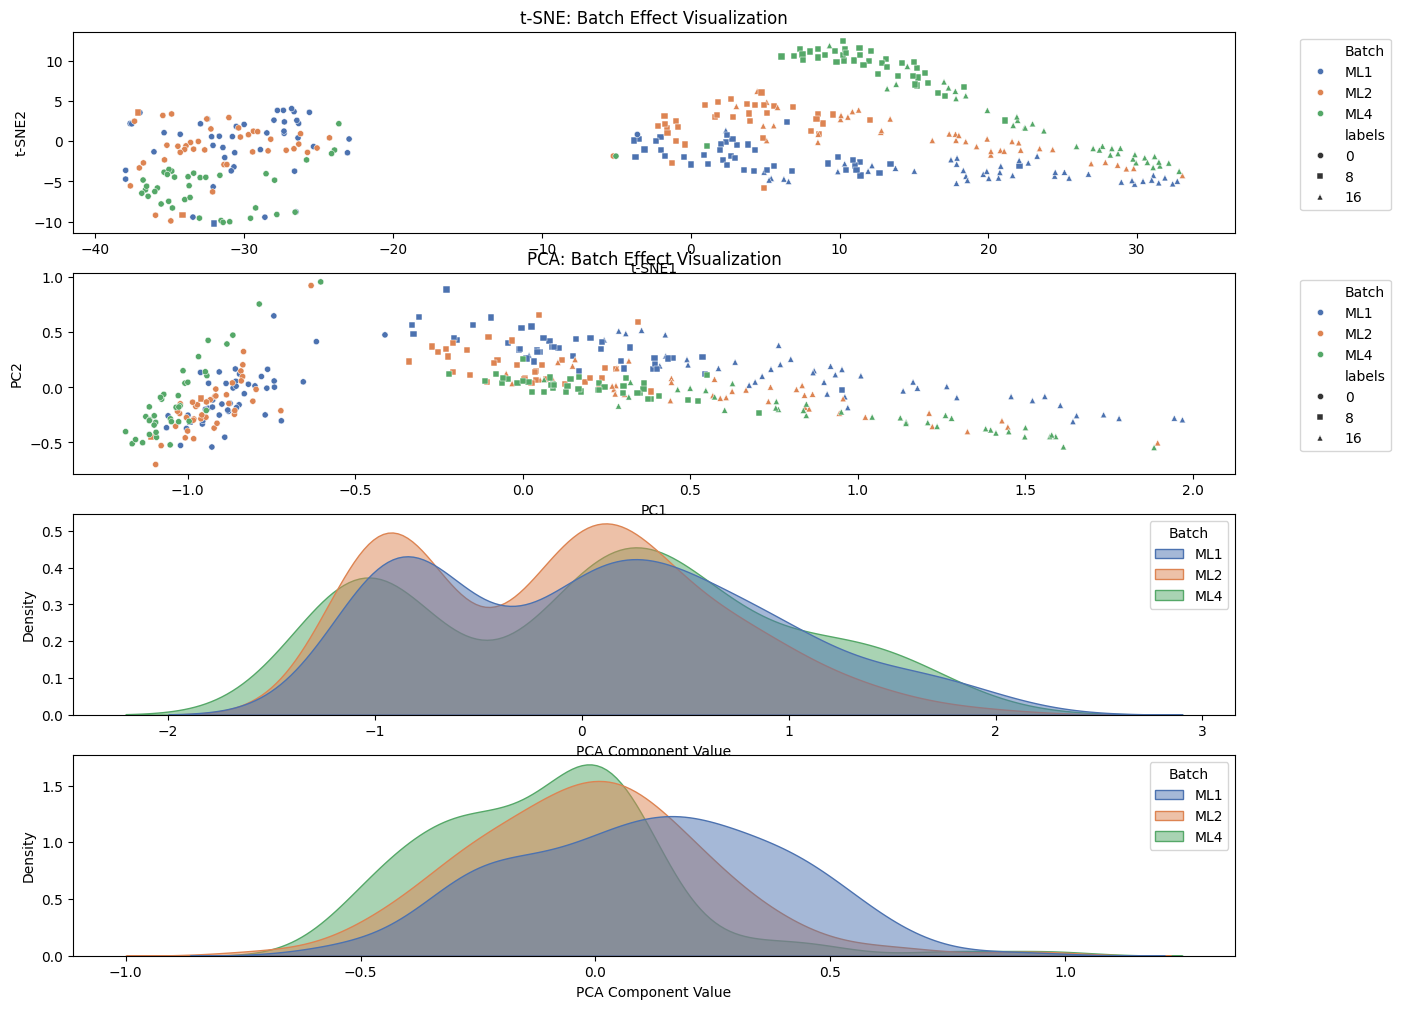

In [121]:
experiment_name = f'batch_effect_{standardize_type}'
tsen_pca_viz(data, batch_labels, labels, filename=experiment_name)

In [122]:
features = data.values

# Apply ComBat
combat      = Combat()
combat_data = combat.fit_transform(features, batch_labels)
combat_df   = pd.DataFrame(combat_data, columns=data.columns)

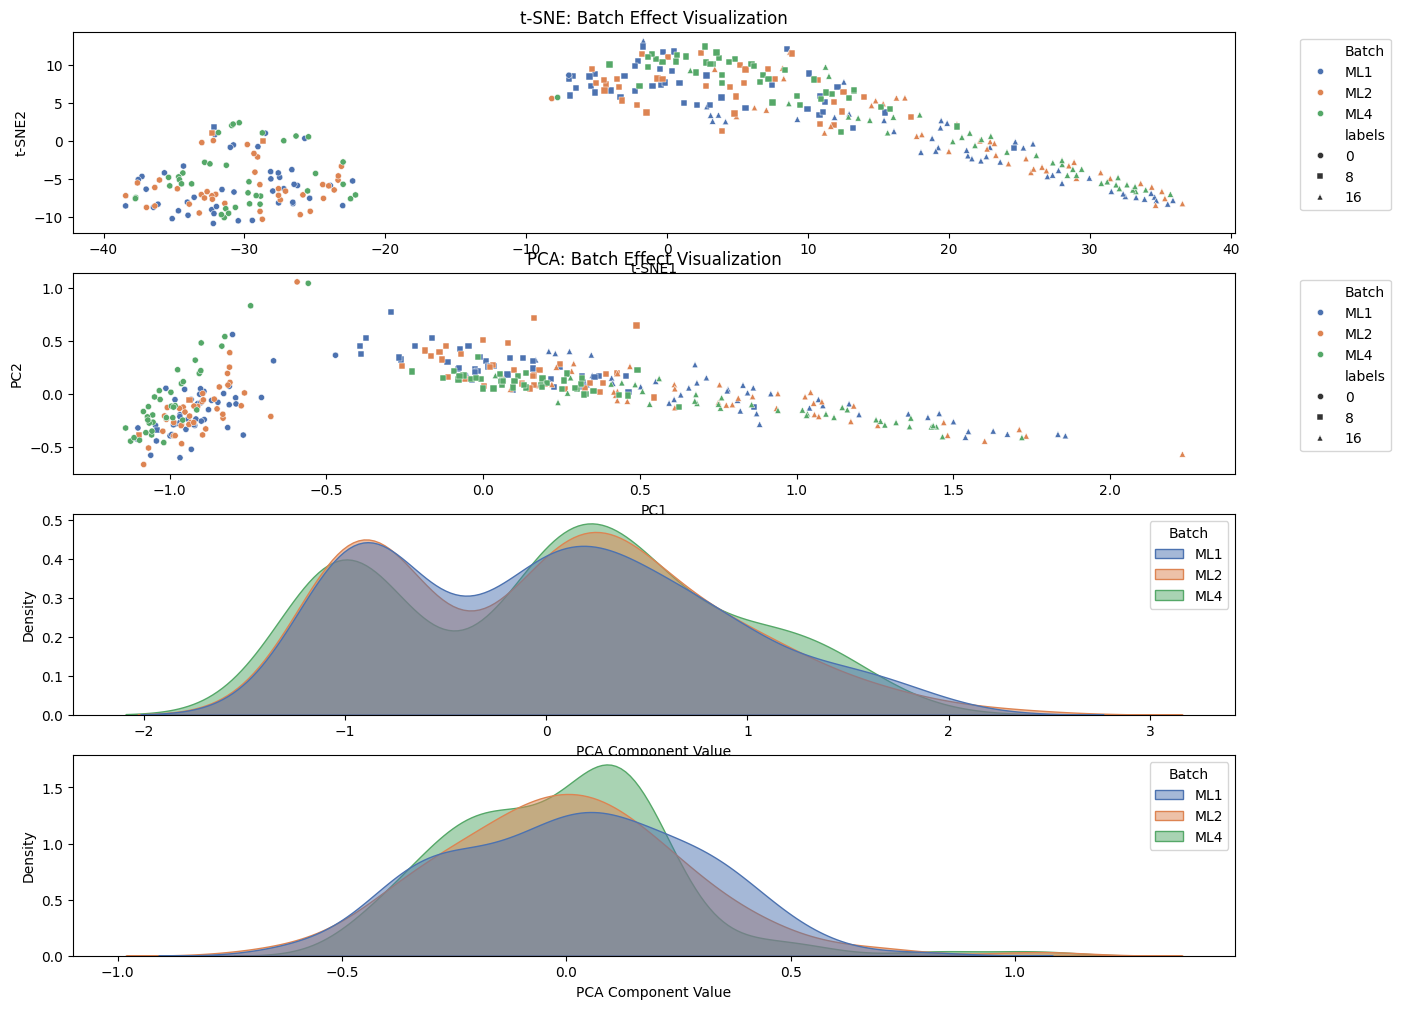

In [123]:
experiment_name = f'batch_effect_{standardize_type}_ComBat'
tsen_pca_viz(combat_df, batch_labels, labels, filename=experiment_name)

In [124]:
# Load normalized dataset
normalization    = True
standardize_type = 'mean_std'
normalize_blanks = True

ML1_X, ML1_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, normalize_blanks=normalize_blanks, split=False)
ML2_X, ML2_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, normalize_blanks=normalize_blanks, split=False)
ML4_X, ML4_y  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/ML4', normalization=normalization, standardize_type=standardize_type, normalize_blanks=normalize_blanks, split=False)

/Users/sangam/Desktop/Epilepsey/Code/vgramreg/src/load_dataset.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={"PH": 'univariate, max(S)', 'signal_std':'univariate, std(S)', 'signal_mean':'univariate, mean(S)', 'peak area':'univariate, area(S)', \
/Users/sangam/Desktop/Epilepsey/Code/vgramreg/src/load_dataset.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={"PH": 'univariate, max(S)', 'signal_std':'univariate, std(S)', 'signal_mean':'univariate, mean(S)', 'peak area':'univariate, area(S)', \
/Users/sangam/Desktop/Epilepsey/Code/vgramreg/src/load_dataset.py:60: SettingWithCop

In [125]:
conc         = 'all'
data         = pd.concat([ML1_X, ML2_X, ML4_X]) if conc=='all' else pd.concat([ML1_X[ML1_y==conc], ML2_X[ML2_y==conc], ML4_X[ML4_y==conc]])
batch_labels = np.repeat(['ML1', 'ML2', 'ML4'], repeats= [len(ML1_X), len(ML2_X), len(ML4_X)] if conc=='all' else [ML1_y.value_counts()[conc], ML2_y.value_counts()[conc], ML4_y.value_counts()[conc]])
labels       = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()

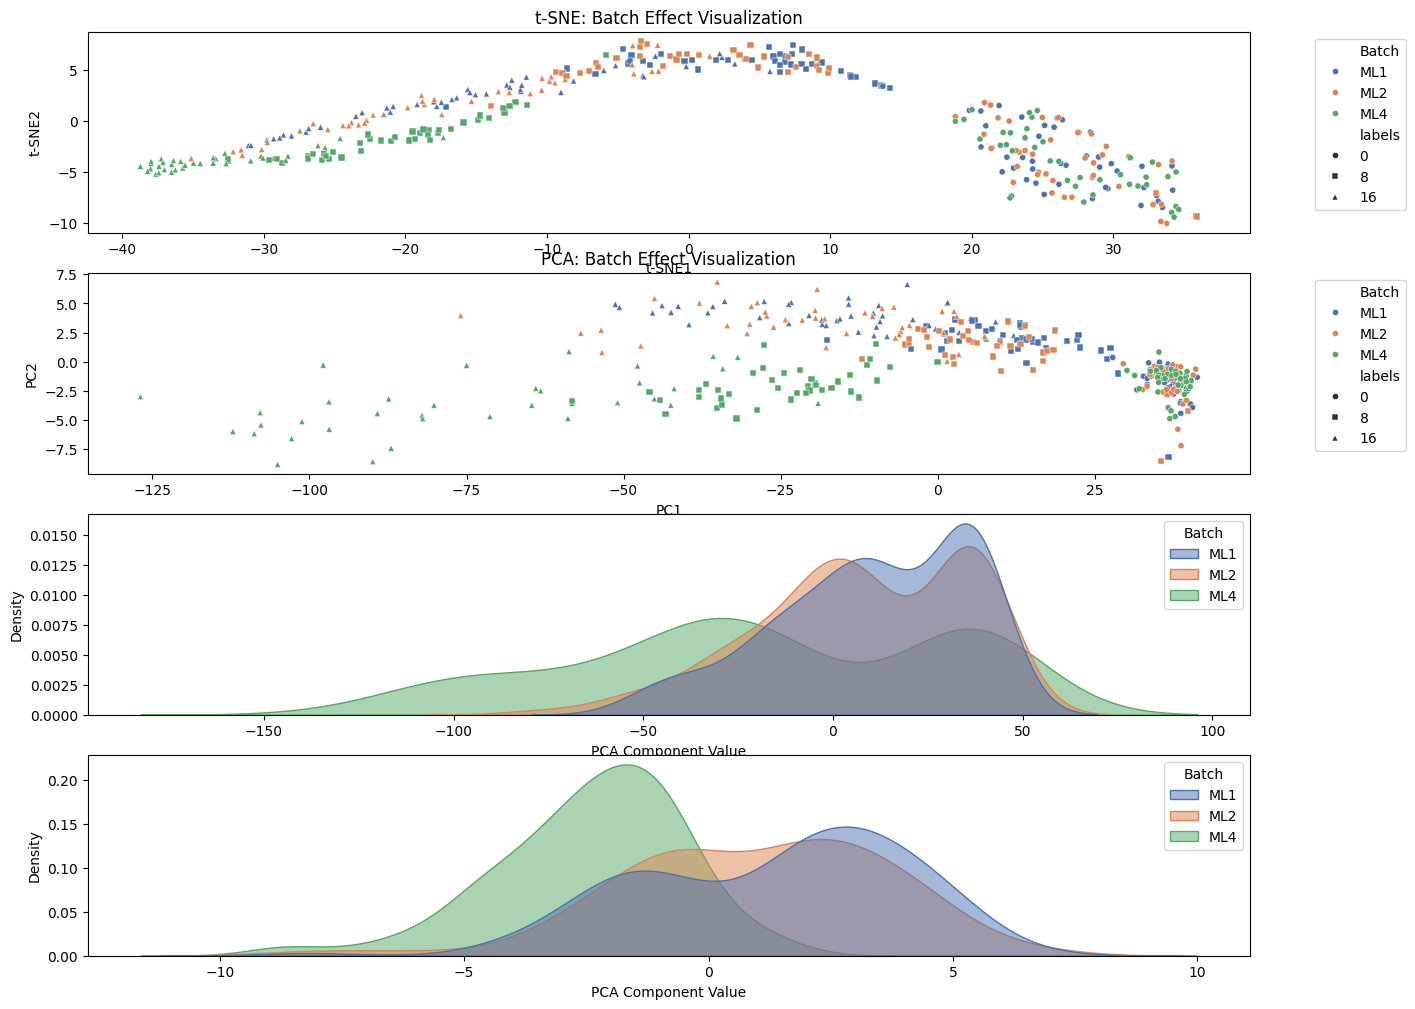

In [126]:
experiment_name = f'batch_effect_nBlank_{standardize_type}'
tsen_pca_viz(data, batch_labels, labels, filename=experiment_name)